# GWP Submission 2: Price a Vanilla European Call Option

*(Referencies: MScFE 630 CF_Compiled_Notes_M4, MScFE 630 CF_Compiled_Notes_M5)*

**Pricing a vanilla European call option:**

1. Using a simple Fourier pricing technique (using 𝑁 = 100 intervals, and using an effective
upper bound of integration of 30), price a vanilla call option assuming that the underlying
share follows the Heston model dynamics. Use the parameter values from the previous
section (GWP #1), as well as the following parameter values:


        𝑣_0 = 0.06
        κ = 9
        θ = 0.06
        𝜌 = −0.4

Parameter values from the previous section (GWP #1):

* Option maturity is one year
* The option is struck at-the-money
* The current share price is 100
* The risk-free continuously compounded interest rate is 8%
* The volatility for the underlying share is 30%

Importing libraries:

In [1]:
import numpy as np
import pandas as pd
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import log,exp,sqrt,stats
import scipy.stats as si
from scipy.stats import ncx2
import warnings
import scipy as sp
warnings.filterwarnings("ignore")
%matplotlib inline

Parameters:

In [2]:
#Parameters:
r = 0.08 #Risk free rate
#Share specific information
S_0 = 100 #Current share price
sigma = 0.3 #Volatility
v_0 = 0.06
kappa = 9
theta = 0.06
rho = -0.4
#Option specific information
K = S_0    #Strike as it`s at-the-money option
T = 1     #Maturity
k_log = np.log(K)
#Approximation information
t_max = 30 #Upper bound
N = 100 #Upper bound for the sum

* We will use the functions from the MScFE 630 CF_Compiled_Notes_M5.

Characteristic functions:

In [3]:
a = sigma**2/2

def b(u):
    return kappa - rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1

def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))
    return (val1/val2)*xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u)*v_0 + 1j*u*np.log(S_0))

def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

We have the functions set, now we will vectorize our code:

In [4]:
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

Calculate the estimate for the integrals:

In [5]:
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

Now, we can calculate the Fourier estimate of our call price:

In [6]:
fourier_call_val = S_0*(1/2 + first_integral/np.pi)-np.exp(-r*T)*K*(1/2 + second_integral/np.pi)
print("Heston model call option price: {:.2f}.".format(fourier_call_val))

Heston model call option price: 13.73.


In order to compare, we can also calculate the call price under Black-Scholes:

In [7]:
d_1_stock = (np.log(S_0/K)+(r + sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_callprice = S_0*norm.cdf(d_1_stock)-K*np.exp(-r*(T))*norm.cdf(d_2_stock)
print("Black-Scholes call price: {:.2f}.".format(analytic_callprice))

Black-Scholes call price: 15.71.


Now, we will plot the integrands for the two integrals:

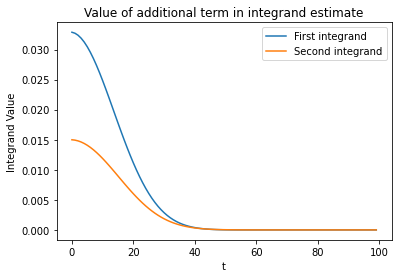

In [8]:
plt.title("Value of additional term in integrand estimate")
plt.plot((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t, label="First integrand")
plt.plot((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t, label="Second integrand")
plt.xlabel("t")
plt.ylabel("Integrand Value")
plt.legend()
plt.show()

2. We will now simulate a share price path. Assume that $\sigma(t_i,t_{i+1}) = \sigma(S_{ti})^{\gamma-1}$, where $\sigma = 0.3$ and $\gamma = 0.75$. Using the formula below, simulate paths for the underlying share using sample sizes of 1000, 2000, …, 50000. Perform monthly simulations for a period of a year. We can simulate the next step in a share price path using the following formula:$$S_{t_{i+1}} = S_{t_i}e^{(r - \frac{\sigma^2 (t_i,t_{i+1})}{2})(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z}$$where $S_{ti}$ is the share price at time $t_i$, $\sigma(t_i, t_{i+1})$ is the volatility for the period $[t_i,t_{i+1}]$, r is the risk-free interest rate, and Z ~ N (0, 1)

Note that we are attempting to run simulations using the CEV model. However, while the CEV model assumes that volatility is a continuous function of time and share price, we are making a simplifying assumption that volatility is constant over each simulation period. 

*(Please note that running the simulations might take 10-15 mins to finish.)*

Parameters for CEV model:

In [9]:
sigma_CEV = 0.3
gamma = 0.75
dT = 1/12 #monthly simulations

Now, we will write a function in order to simulate the next step in a share price path using the formula from above:

In [10]:
#function for Volatility from CEV Model
def CEV_vol(sigm,sT,gamman):
    return sigm*sT**(gamman-1) 

In [11]:
def term_prices(s_0,T,r,sigm,no_sim,gamman):
    """
        Returns: terminal values of simulated price paths
    """
    n_steps= 12 # Define number of steps.
    dt = T/n_steps
    prices=[None]*no_sim
    for j in range(0,no_sim):
        sT = s_0
        for i in range(0,int(n_steps)):
            random.seed(24)
            e = sp.random.normal()
            vol = CEV_vol(sigm,sT,gamman)
            sT *= np.exp((r-0.5*vol**2)*dt+vol*e*np.sqrt(dt))
        prices[j]=sT
    return prices

In [12]:
no_sim = 1000  # number of simulations
random.seed(4)
#Empty array which can be used to store estimate values for different sample sizes
price_path=[None]*50
#simulating 1000,2000...,50000 sample paths terminal values
price_path=[None]*50
for i in range(1,51):
    price=term_prices(S_0,T,r,sigma,no_sim*i,gamma)
    price_path[i-1]=np.mean(price)

Plotting terminal values of simulated price paths:

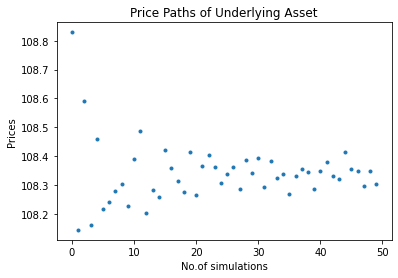

In [13]:
plt.plot(price_path, ".")
plt.xlabel("No.of simulations")
plt.ylabel("Prices")
plt.title("Price Paths of Underlying Asset")
plt.show()

3. Augment your code in part 2 to calculate Monte Carlo estimates, as well as the standard
deviations for these estimates, for the price of a vanilla call option (with the same strike term
as in Submission 1).

Function in order to calculate the value of European Option:

In [14]:
def option_prices(s_0,T,K,r,sigm,no_sim,gamman):
    """
        Returns: Call value of European Option
    """
    n_steps= 12 # Define number of steps.
    dt = T/n_steps
    prices=[None]*no_sim
    for j in range(0,no_sim):
        sT=s_0
        for i in range(0,int(n_steps)):
            random.seed(24)
            e = sp.random.normal()
            vol = CEV_vol(sigm,sT,gamman)
            sT *= np.exp((r-0.5*vol**2)*dt+vol*e*np.sqrt(dt))
        prices[j] = np.exp(-r*T)*np.maximum(sT-K,0)
    return prices

Simulating 1000,2000...,50000 option paths:

In [15]:
random.seed(4)
#Empty arrays which can be used to store estimate values for different sample sizes
mcall_std=[None]*50
mcall_estimates = [None]*50
for i in range(1,51):
    prices=option_prices(S_0,T,K,r,sigma,no_sim*i,gamma)
    mcall_estimates[i-1] = np.mean(prices)
    mcall_std[i-1] = np.std(prices)/np.sqrt(i*1000)

mean = np.mean(mcall_estimates)

In [32]:
print("The final option value estimate by Monte Carlo for the sample size of 50,000: {:.2f}.".format(mcall_estimates[i-1]))

The final option value estimate by Monte Carlo for the sample size of 50,000: 8.73.


Call price under CEV model:

In [17]:
z = 2 + 1/(1-gamma)

def C(S0, t, K):
    kappa = 2*r/(sigma_CEV**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-ncx2.cdf(y,z,x))-K*np.exp(-r*t)*ncx2.cdf(x,z-2,y)

In [18]:
CEV_call = C(S_0, T, K)
print("Call option price under CEV model: {:.2f}.".format(CEV_call))

Call option price under CEV model: 8.70.


4. Plot the Monte Carlo estimates generated in part 3 with respect to sample size, as well as three standard deviation error bounds around these estimates. 

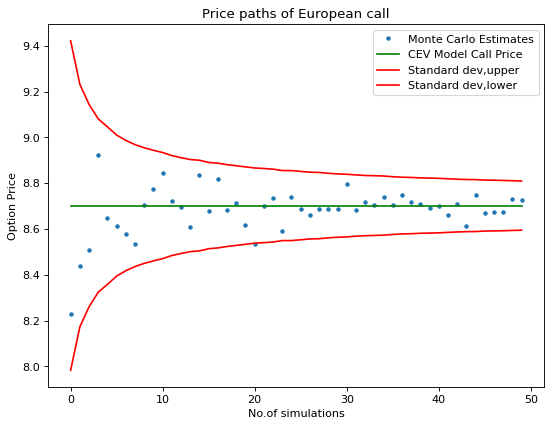

In [19]:
figure(figsize=(8, 6), dpi=80)
plt.plot(mcall_estimates, ".")
plt.plot([CEV_call]*50, "g")
plt.plot(CEV_call+np.array(mcall_std)*3, "r")
plt.plot(CEV_call-np.array(mcall_std)*3, "r")
plt.xlabel("No.of simulations")
plt.ylabel("Option Price")
plt.legend(["Monte Carlo Estimates","CEV Model Call Price","Standard dev,upper","Standard dev,lower"])
plt.title("Price paths of European call")
plt.show()

**Volatility Smile:**

5. Graph the volatility smile:

* Visit https://finance.yahoo.com/quote/FB/options/
* Find the strike closest to the current price of Facebook stock (take whatever maturity/ies you’d like). Call this K. Find its volatility. Call this sigma
* Then find the 3 closest strikes below K. Find their implied volatilities from the website.
* Then find the 3 closest strikes above K. Find their implied volatilities from the website.
* Graph the strikes along the x-axis, and the implied volatilities along the y-axis.
* Label this graph the “Facebook Option Volatility Smile”.

* Facebook stock closing price as of 15th of October: 324.76.


* The closest Strike is: 325, with sigma: 31.03%.


* We choose maturity on the 22nd of October.

* The 3 closest strikes below K and their implied volatility:
                        322.5 & 31.59%
                        320   & 32.34%
                        317.5 & 32.76%
                        
* The 3 closest strikes above K and their implied volatility:
                        327.5 & 30.87%
                        330   & 30.57%
                        332.5 & 30.50%
                        

*K_a means strike above* & *K_b means strike below*:

In [20]:
K_0 = 325
sigma_0 = 31.03
K_a1 = 327.5
sigma_a1 = 30.87
K_a2 = 330
sigma_a2 = 30.57
K_a3 = 332.5
sigma_a3 = 30.50
K_b1 = 322.5
sigma_b1 = 31.59
K_b2 = 320
sigma_b2 = 32.34
K_b3 = 317.5
sigma_b3 = 32.76

Creating data frames:

In [21]:
strikes_df = [K_b3, K_b2, K_b1, K_0, K_a1, K_a2, K_a3]
volatility_df = [sigma_b3, sigma_b2, sigma_b1, sigma_0, sigma_a1, sigma_a2, sigma_a3]

Plotting the strikes on x-axis and implied volatility on y-axis:

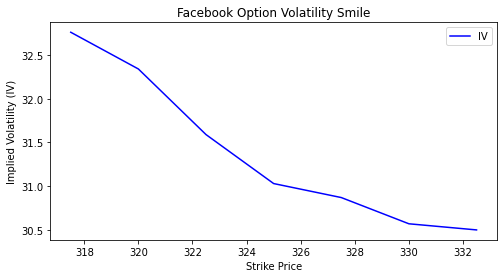

In [22]:
plt.subplots(figsize=(8, 4))
plt.plot(strikes_df, volatility_df, 'b')
plt.title("Facebook Option Volatility Smile")
plt.legend(['IV'])
plt.ylabel('Implied Volatility (IV)')
plt.xlabel('Strike Price')           
plt.show()

* Well, it`s not exactly a smile, the shape of volatility smile should be a symmetry convex curve, but what we see above is rather called skewed shape.


* As we can see, from the above chart, the implied volatility curve slopes downward to the right. This called the skew, meaning that options with low strikes have higher implied volatility, compared to higher strikes.


* Usually, on call options implied volatility tends to be higher for deep ITM options and decreasing as moves closer to OTM options, which is the case as the graph shows above. Based on this we can assume that most of the investors are long FB shares.

6. Write a function to compute the implied volatility (Hint: Think bisection algorithm as one of the choices). Use this function to validate at least 2 of the implied volatilities from the website. Note: Feel free to use the 1-month T-Bill as the risk-free rate.

                    1-month T-Bill as the risk-free rate: 0.04% as of 15th of October.


We decided to go with Newton-Raphson Method of root finding as we found more research on this method.


* First we need to define two functions, one for calculating the vega and the other to calculate the analytical call price of the option.

Function for Vega:

In [23]:
def vega(S0, K, T, t_bill, sigma):

    #S0: spot price
    #K: strike price
    #T: time to maturity
    #t_bill: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S0 / K) + (t_bill + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    vega = S0 * si.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    
    return vega

Function for the analytic call price:

In [24]:
def analytic_callprice(S0, K, T, sigma, t_bill):
    d_1_stock = (np.log(S0/K)+(t_bill + sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d_2_stock = d_1_stock - sigma*np.sqrt(T)
    return S0*norm.cdf(d_1_stock)-K*np.exp(-t_bill*(T))*norm.cdf(d_2_stock)

Using Newton-Raphson Method of root finding, the function calculates the implied volatility of a Vanilla European Call Option:

In [25]:
def implied_vol(S0, K, T, t_bill, opt_price, tolerance=0.00000001):
    #opt_price: market price of the option taken from yahoo finance
    iterations = 50 
    sigma = sigma_0/100 #Initial value of volatility
    
    #Newton-Raphson method:
    for k in range(iterations):
        analytic_price = analytic_callprice(S0, K, T, sigma, t_bill)
        Vega = vega(S0, K, T, t_bill, sigma)*100
        diff_price = analytic_price - opt_price

        new_sigma = sigma - diff_price/Vega
        new_analytic_callprice = analytic_callprice(S0, K, T, new_sigma, t_bill)
        if (abs(sigma-new_sigma) < tolerance or abs(new_analytic_callprice-opt_price) < tolerance):
            break

        sigma = new_sigma

    implied_vol = new_sigma
    return implied_vol

* We choose to validate the two following strikes K_a1 = 327.50 & K_a2 = 330.


* K_a1`s opt_price_a1 = 4.22
* K_a2`s opt_price_a2 = 3.24

In [26]:
#Current FB stock and option prices for the corresponding strikes:
S0 = 324.76 #Stock prices as of today
opt_price_a1 = 4.22 #Option price as of today from yahoo finance
opt_price_a2 = 3.24 #Option price as of today from yahoo finance
T = 6/365 #Time to option expiry
t_bill = 0.0004 #1-month T-Bill as the risk-free rate

* Implied volatility for K_a1 = 327.50:

In [27]:
print("Implied volatility for K = 327.50 is {:.2f}%.".format(implied_vol(S0, K_a1, T, t_bill, opt_price_a1)*100))

Implied volatility for K = 327.50 is 31.71%.


* Implied volatility for K_a2 = 330:

In [28]:
print("Implied volatility for K = 330 is {:.2f}%.".format(implied_vol(S0, K_a2, T, t_bill, opt_price_a2)*100))

Implied volatility for K = 330 is 31.69%.


As we can see we got 31.71% for K = 327.50, the implied volatility from yahoo finance as of the close at the 15th is 30.87%, so, our estimate 31.71% is very close as the difference is less than 1%. 

For K = 330, the difference is just a bit more than 1% as we got 31.69%, and on yahoo finance it`s 30.57%, still our estimate is very close.

* 7. The volatility skewness is defined as the change in implied volatility (delta y) divided by the
change in strike level (delta x). Using the strikes below K, calculate the volatility skew for
Facebook.

K_b1 = 325
sigma_b1 = 41.59
K_b2 = 320
sigma_b2 = 42.37
K_b3 = 315
sigma_b3 = 43.37

In [29]:
delta_y = sigma_b3 / sigma_b1 -1
delta_x = K_b3 / K_b1 -1
vol_skew = delta_y / delta_x
print("Volatility skewness is {:.2f}.".format(vol_skew))

Volatility skewness is -2.39.


* 8. In Black Scholes, does the volatility depend on the strike level? Why or why not?

No, it does not. The Black-Scholes world assumes that all assets have their own constant volatility, meaning that regardless of the strike or maturity of an option the volatility for the underlying asset is the same. In this case the implied volatility surface would be flat which means the implied volatility be the same for all strikes and maturities.

Of course it`s not true in the real world.

* 9. How does the Heston Model better estimate the volatility smile? Specifically, what is different in Heston’s model from Black Scholes that allows more estimate option pricing?

* Black Scholes assumes that the asset prices are log-normally distributed, Heston model is the opposite meaning asset prices are Not log-normally distributed.

* Black Scholes assumes that the risk-free rate and volatility are constant, Heston model says volatility is not constant it fluctuates and rarely remains constant, Heston model also says that the volatility is mean reverting. 

* Based on Black Scholes the volatility should be a flat line, in the Heston model shape of volatility smile should be a symmetry convex curve.

* Also the Heston model captures the leverage effect and it`s possible to calibrate fast to market data.